In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_xcit_model(num_classes=4, pretrained=True, model_type="tiny"):
    """
    Create XCiT (Cross-Covariance Image Transformer) Medium P16 model
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: XCiT Medium P16 model
    """
    
    model = timm.create_model(f'xcit_{model_type}_24_p16_224', pretrained=pretrained, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


# Train XCiT Tiny P16

Training XCiT Medium P16


model.safetensors:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.3128, Acc=0.4285]


Train Loss: 1.3128 Acc: 0.4285 Macro-F1: 0.3980


Val : 100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Loss=0.9229, Acc=0.5987]


Val Loss: 0.9229 Acc: 0.5987 Macro-F1: 0.4434
✓ New best model saved with validation macro-F1: 0.4434

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, Loss=0.9939, Acc=0.5674]


Train Loss: 0.9939 Acc: 0.5674 Macro-F1: 0.5201


Val : 100%|██████████| 10/10 [00:01<00:00,  8.30it/s, Loss=0.9995, Acc=0.6151]


Val Loss: 0.9995 Acc: 0.6151 Macro-F1: 0.5586
✓ New best model saved with validation macro-F1: 0.5586

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, Loss=0.9156, Acc=0.6382]


Train Loss: 0.9156 Acc: 0.6382 Macro-F1: 0.5809


Val : 100%|██████████| 10/10 [00:01<00:00,  8.65it/s, Loss=0.9385, Acc=0.6118]


Val Loss: 0.9385 Acc: 0.6118 Macro-F1: 0.5793
✓ New best model saved with validation macro-F1: 0.5793

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.9913, Acc=0.5674]


Train Loss: 0.9913 Acc: 0.5674 Macro-F1: 0.5173


Val : 100%|██████████| 10/10 [00:01<00:00,  8.78it/s, Loss=1.0110, Acc=0.4605]


Val Loss: 1.0110 Acc: 0.4605 Macro-F1: 0.4556

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.8479, Acc=0.6020]


Train Loss: 0.8479 Acc: 0.6020 Macro-F1: 0.5836


Val : 100%|██████████| 10/10 [00:01<00:00,  7.97it/s, Loss=0.7769, Acc=0.6678]


Val Loss: 0.7769 Acc: 0.6678 Macro-F1: 0.6503
✓ New best model saved with validation macro-F1: 0.6503

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.8109, Acc=0.7039]


Train Loss: 0.8109 Acc: 0.7039 Macro-F1: 0.6480


Val : 100%|██████████| 10/10 [00:01<00:00,  8.46it/s, Loss=1.0693, Acc=0.5625]


Val Loss: 1.0693 Acc: 0.5625 Macro-F1: 0.5291

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.7903, Acc=0.6859]


Train Loss: 0.7903 Acc: 0.6859 Macro-F1: 0.6490


Val : 100%|██████████| 10/10 [00:01<00:00,  8.84it/s, Loss=0.8554, Acc=0.6875]


Val Loss: 0.8554 Acc: 0.6875 Macro-F1: 0.6560
✓ New best model saved with validation macro-F1: 0.6560

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.5833, Acc=0.7870]


Train Loss: 0.5833 Acc: 0.7870 Macro-F1: 0.7605


Val : 100%|██████████| 10/10 [00:01<00:00,  8.28it/s, Loss=0.4571, Acc=0.8520]


Val Loss: 0.4571 Acc: 0.8520 Macro-F1: 0.8368
✓ New best model saved with validation macro-F1: 0.8368

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.4191, Acc=0.8602]


Train Loss: 0.4191 Acc: 0.8602 Macro-F1: 0.8367


Val : 100%|██████████| 10/10 [00:01<00:00,  8.39it/s, Loss=0.4124, Acc=0.8618]


Val Loss: 0.4124 Acc: 0.8618 Macro-F1: 0.8487
✓ New best model saved with validation macro-F1: 0.8487

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.3190, Acc=0.8939]


Train Loss: 0.3190 Acc: 0.8939 Macro-F1: 0.8842


Val : 100%|██████████| 10/10 [00:01<00:00,  8.78it/s, Loss=0.3541, Acc=0.8553]


Val Loss: 0.3541 Acc: 0.8553 Macro-F1: 0.8537
✓ New best model saved with validation macro-F1: 0.8537

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.2890, Acc=0.8939]


Train Loss: 0.2890 Acc: 0.8939 Macro-F1: 0.8818


Val : 100%|██████████| 10/10 [00:01<00:00,  8.62it/s, Loss=0.3581, Acc=0.8618]


Val Loss: 0.3581 Acc: 0.8618 Macro-F1: 0.8306

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.75it/s, Loss=0.2338, Acc=0.9120]


Train Loss: 0.2338 Acc: 0.9120 Macro-F1: 0.9094


Val : 100%|██████████| 10/10 [00:01<00:00,  8.63it/s, Loss=0.2881, Acc=0.8882]


Val Loss: 0.2881 Acc: 0.8882 Macro-F1: 0.8921
✓ New best model saved with validation macro-F1: 0.8921

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, Loss=0.1780, Acc=0.9350]


Train Loss: 0.1780 Acc: 0.9350 Macro-F1: 0.9384


Val : 100%|██████████| 10/10 [00:01<00:00,  8.67it/s, Loss=0.2382, Acc=0.9145]


Val Loss: 0.2382 Acc: 0.9145 Macro-F1: 0.9094
✓ New best model saved with validation macro-F1: 0.9094

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.1892, Acc=0.9285]


Train Loss: 0.1892 Acc: 0.9285 Macro-F1: 0.9239


Val : 100%|██████████| 10/10 [00:01<00:00,  8.59it/s, Loss=0.2590, Acc=0.8947]


Val Loss: 0.2590 Acc: 0.8947 Macro-F1: 0.8884

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, Loss=0.1402, Acc=0.9457]


Train Loss: 0.1402 Acc: 0.9457 Macro-F1: 0.9518


Val : 100%|██████████| 10/10 [00:01<00:00,  8.15it/s, Loss=0.2390, Acc=0.9046]


Val Loss: 0.2390 Acc: 0.9046 Macro-F1: 0.8979

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, Loss=0.1297, Acc=0.9531]


Train Loss: 0.1297 Acc: 0.9531 Macro-F1: 0.9566


Val : 100%|██████████| 10/10 [00:01<00:00,  8.54it/s, Loss=0.2316, Acc=0.9112]


Val Loss: 0.2316 Acc: 0.9112 Macro-F1: 0.9071

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, Loss=0.1208, Acc=0.9507]


Train Loss: 0.1208 Acc: 0.9507 Macro-F1: 0.9528


Val : 100%|██████████| 10/10 [00:01<00:00,  8.55it/s, Loss=0.2219, Acc=0.9145]


Val Loss: 0.2219 Acc: 0.9145 Macro-F1: 0.9052

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.1175, Acc=0.9531]


Train Loss: 0.1175 Acc: 0.9531 Macro-F1: 0.9538


Val : 100%|██████████| 10/10 [00:01<00:00,  8.60it/s, Loss=0.2158, Acc=0.9178]


Val Loss: 0.2158 Acc: 0.9178 Macro-F1: 0.9119
✓ New best model saved with validation macro-F1: 0.9119

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.1044, Acc=0.9622]


Train Loss: 0.1044 Acc: 0.9622 Macro-F1: 0.9651


Val : 100%|██████████| 10/10 [00:01<00:00,  8.57it/s, Loss=0.2138, Acc=0.9211]


Val Loss: 0.2138 Acc: 0.9211 Macro-F1: 0.9147
✓ New best model saved with validation macro-F1: 0.9147

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.75it/s, Loss=0.1046, Acc=0.9638]


Train Loss: 0.1046 Acc: 0.9638 Macro-F1: 0.9663


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=0.2029, Acc=0.9309]


Val Loss: 0.2029 Acc: 0.9309 Macro-F1: 0.9228
✓ New best model saved with validation macro-F1: 0.9228

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.73it/s, Loss=0.1131, Acc=0.9581]


Train Loss: 0.1131 Acc: 0.9581 Macro-F1: 0.9584


Val : 100%|██████████| 10/10 [00:01<00:00,  6.77it/s, Loss=0.2042, Acc=0.9309]


Val Loss: 0.2042 Acc: 0.9309 Macro-F1: 0.9228

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0932, Acc=0.9605]


Train Loss: 0.0932 Acc: 0.9605 Macro-F1: 0.9638


Val : 100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Loss=0.2015, Acc=0.9309]


Val Loss: 0.2015 Acc: 0.9309 Macro-F1: 0.9228

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.1011, Acc=0.9605]


Train Loss: 0.1011 Acc: 0.9605 Macro-F1: 0.9627


Val : 100%|██████████| 10/10 [00:01<00:00,  7.55it/s, Loss=0.2046, Acc=0.9375]


Val Loss: 0.2046 Acc: 0.9375 Macro-F1: 0.9321
✓ New best model saved with validation macro-F1: 0.9321

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0897, Acc=0.9704]


Train Loss: 0.0897 Acc: 0.9704 Macro-F1: 0.9738


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.2005, Acc=0.9309]


Val Loss: 0.2005 Acc: 0.9309 Macro-F1: 0.9227

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0896, Acc=0.9671]


Train Loss: 0.0896 Acc: 0.9671 Macro-F1: 0.9693


Val : 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Loss=0.1984, Acc=0.9342]


Val Loss: 0.1984 Acc: 0.9342 Macro-F1: 0.9253

Training complete in 9m 40s
Best validation macro-F1: 0.9321


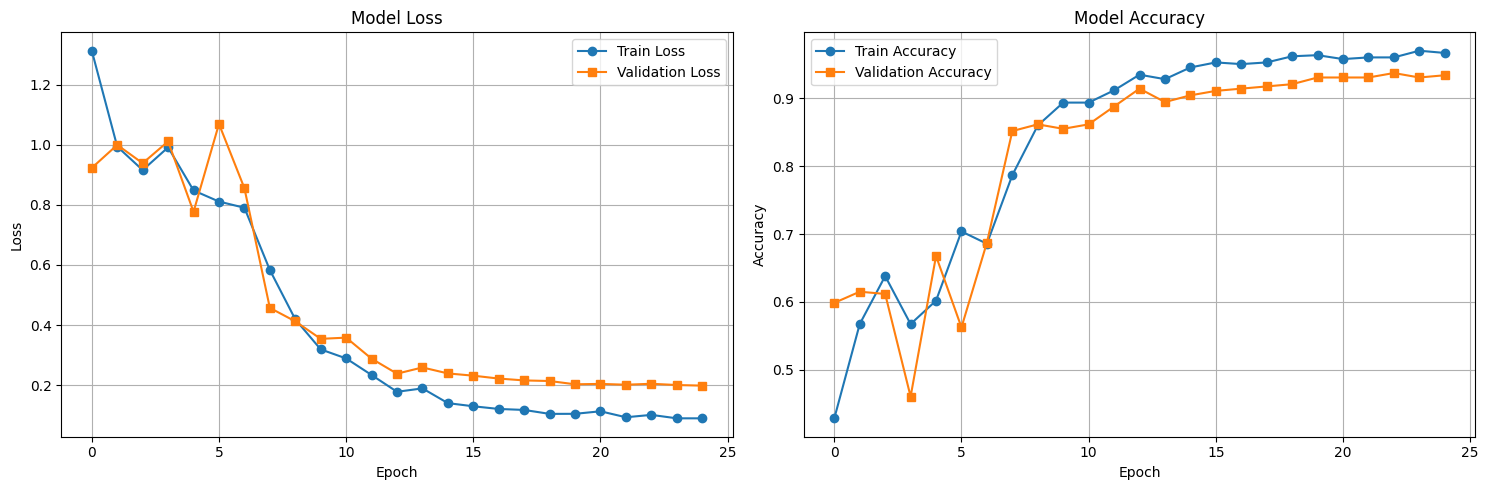

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Test Accuracy: 54.50%
Test Loss: 2.0666

Classification Report:
              precision    recall  f1-score   support

         HGC       0.68      0.68      0.68        74
         LGC       0.39      0.21      0.27        53
         NST       0.60      0.65      0.62        37
         NTL       0.38      0.72      0.49        25

    accuracy                           0.54       189
   macro avg       0.51      0.56      0.52       189
weighted avg       0.55      0.54      0.53       189


Confusion Matrix:
[[50 11  8  5]
 [20 11  5 17]
 [ 1  4 24  8]
 [ 2  2  3 18]]

ROC-AUC Scores:
Macro-average AUC: 0.7462
Micro-average AUC: 0.7521
HGC AUC: 0.7996
LGC AUC: 0.5014
NST AUC: 0.8739
NTL AUC: 0.8100


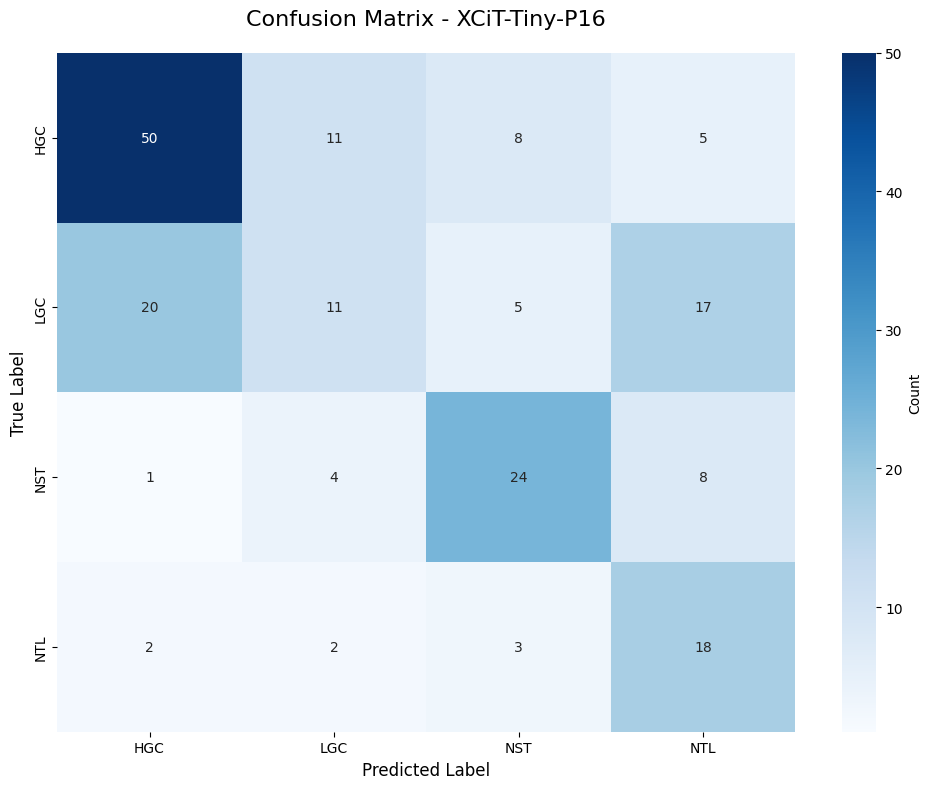

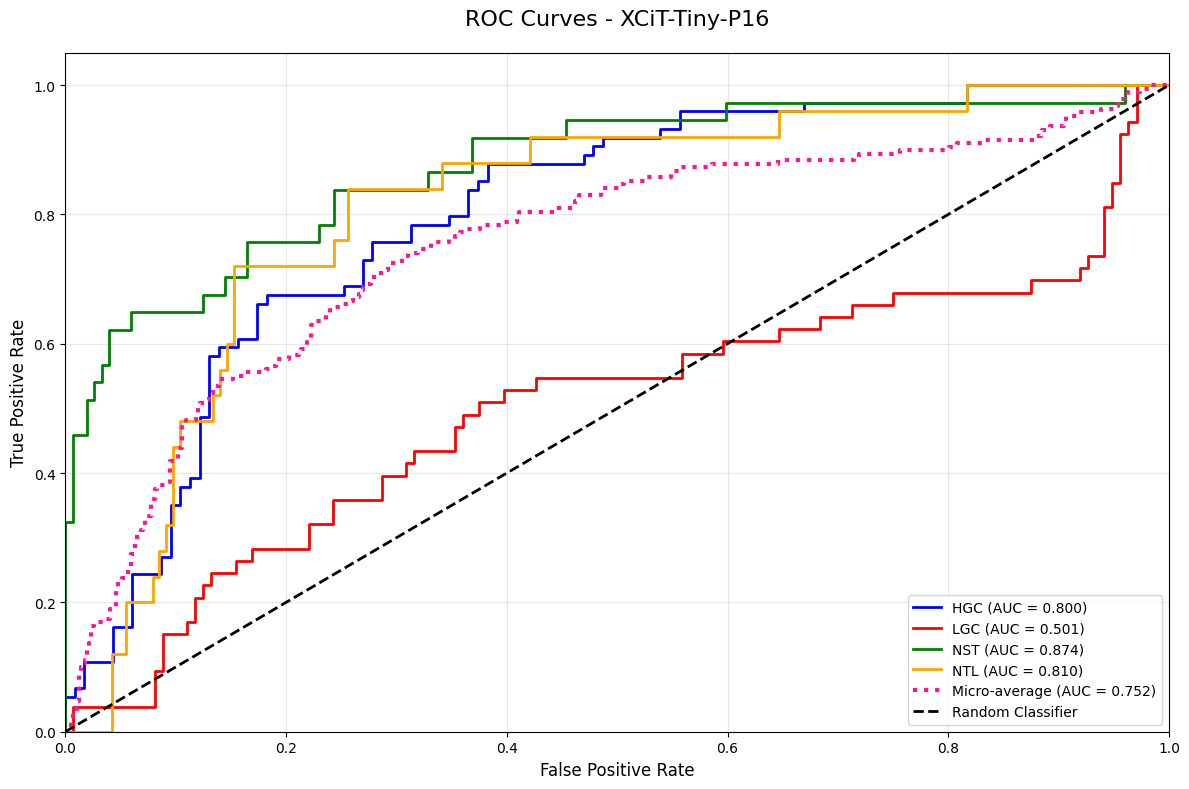


XCiT Tiny P16 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training XCiT Tiny P16")
print("=" * 80)

# Create model
xcit_tiny = create_xcit_model(num_classes=4, pretrained=True, model_type='tiny')

# Create trainer
trainer_xcit_tiny = ModelTrainer(xcit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_tiny = trainer_xcit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Tiny-P16")

# Plot training history
trainer_xcit_tiny.plot_training_history(save_path='xcit_tiny_p16_training_history.png')

# Evaluate model
results_xcit_tiny = trainer_xcit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_tiny['confusion_matrix'], class_names, 'XCiT-Tiny-P16',
                      save_path='xcit_tiny_p16_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_tiny = plot_roc_curves(results_xcit_tiny['labels'], results_xcit_tiny['probabilities'], class_names, 'XCiT-Tiny-P16',
                                       save_path='xcit_tiny_p16_roc_curves.png')

# Store results
results_xcit_tiny['model_name'] = 'XCiT-Tiny-P16'
results_xcit_tiny['roc_auc'] = roc_auc_xcit_tiny
all_results.append(results_xcit_tiny)

print("\nXCiT Tiny P16 training and evaluation complete!")

# Train XCiT Small P1

Training XCiT Small P16


model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.21s/it, Loss=1.4114, Acc=0.3470]


Train Loss: 1.4114 Acc: 0.3470 Macro-F1: 0.3091


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.4371, Acc=0.1217]


Val Loss: 1.4371 Acc: 0.1217 Macro-F1: 0.1145
✓ New best model saved with validation macro-F1: 0.1145

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.3614, Acc=0.3331]


Train Loss: 1.3614 Acc: 0.3331 Macro-F1: 0.3074


Val : 100%|██████████| 10/10 [00:01<00:00,  5.10it/s, Loss=1.4349, Acc=0.3816]


Val Loss: 1.4349 Acc: 0.3816 Macro-F1: 0.1715
✓ New best model saved with validation macro-F1: 0.1715

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:44<00:00,  1.18s/it, Loss=1.1669, Acc=0.4762]


Train Loss: 1.1669 Acc: 0.4762 Macro-F1: 0.4015


Val : 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Loss=1.0245, Acc=0.5461]


Val Loss: 1.0245 Acc: 0.5461 Macro-F1: 0.3970
✓ New best model saved with validation macro-F1: 0.3970

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=1.0583, Acc=0.5066]


Train Loss: 1.0583 Acc: 0.5066 Macro-F1: 0.4310


Val : 100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Loss=0.9093, Acc=0.4572]


Val Loss: 0.9093 Acc: 0.4572 Macro-F1: 0.4031
✓ New best model saved with validation macro-F1: 0.4031

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.0391, Acc=0.5181]


Train Loss: 1.0391 Acc: 0.5181 Macro-F1: 0.4906


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=1.0314, Acc=0.4671]


Val Loss: 1.0314 Acc: 0.4671 Macro-F1: 0.3257

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.9918, Acc=0.5436]


Train Loss: 0.9918 Acc: 0.5436 Macro-F1: 0.4924


Val : 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Loss=1.3720, Acc=0.3553]


Val Loss: 1.3720 Acc: 0.3553 Macro-F1: 0.3090

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.9942, Acc=0.5132]


Train Loss: 0.9942 Acc: 0.5132 Macro-F1: 0.4803


Val : 100%|██████████| 10/10 [00:01<00:00,  5.10it/s, Loss=1.4147, Acc=0.3586]


Val Loss: 1.4147 Acc: 0.3586 Macro-F1: 0.2924

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.8224, Acc=0.5641]


Train Loss: 0.8224 Acc: 0.5641 Macro-F1: 0.5439


Val : 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=0.8201, Acc=0.6151]


Val Loss: 0.8201 Acc: 0.6151 Macro-F1: 0.5610
✓ New best model saved with validation macro-F1: 0.5610

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.7809, Acc=0.6143]


Train Loss: 0.7809 Acc: 0.6143 Macro-F1: 0.5883


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.7725, Acc=0.6678]


Val Loss: 0.7725 Acc: 0.6678 Macro-F1: 0.6492
✓ New best model saved with validation macro-F1: 0.6492

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.6844, Acc=0.6480]


Train Loss: 0.6844 Acc: 0.6480 Macro-F1: 0.6371


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=0.7069, Acc=0.7007]


Val Loss: 0.7069 Acc: 0.7007 Macro-F1: 0.6796
✓ New best model saved with validation macro-F1: 0.6796

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.6569, Acc=0.6168]


Train Loss: 0.6569 Acc: 0.6168 Macro-F1: 0.6242


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.6657, Acc=0.6382]


Val Loss: 0.6657 Acc: 0.6382 Macro-F1: 0.5651

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.6141, Acc=0.6266]


Train Loss: 0.6141 Acc: 0.6266 Macro-F1: 0.6299


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=0.5920, Acc=0.6579]


Val Loss: 0.5920 Acc: 0.6579 Macro-F1: 0.6166

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.5765, Acc=0.6373]


Train Loss: 0.5765 Acc: 0.6373 Macro-F1: 0.6547


Val : 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=0.6384, Acc=0.6743]


Val Loss: 0.6384 Acc: 0.6743 Macro-F1: 0.6194

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.5810, Acc=0.6933]


Train Loss: 0.5810 Acc: 0.6933 Macro-F1: 0.6537


Val : 100%|██████████| 10/10 [00:02<00:00,  4.81it/s, Loss=0.6674, Acc=0.5658]


Val Loss: 0.6674 Acc: 0.5658 Macro-F1: 0.5129

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=0.5561, Acc=0.5609]


Train Loss: 0.5561 Acc: 0.5609 Macro-F1: 0.5392


Val : 100%|██████████| 10/10 [00:01<00:00,  5.14it/s, Loss=0.5742, Acc=0.5921]


Val Loss: 0.5742 Acc: 0.5921 Macro-F1: 0.5641
Early stopping triggered after 15 epochs
Training complete in 11m 53s
Best validation macro-F1: 0.6796


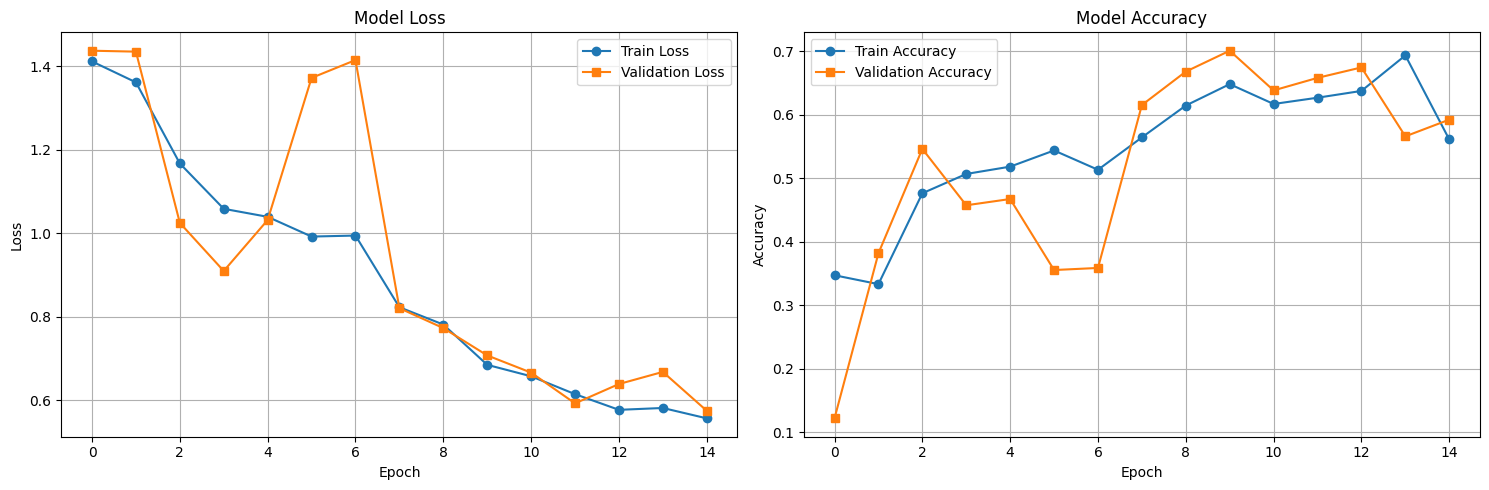

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Test Accuracy: 14.81%
Test Loss: 1.7503

Classification Report:
              precision    recall  f1-score   support

         HGC       0.07      0.03      0.04        74
         LGC       0.00      0.00      0.00        53
         NST       0.23      0.08      0.12        37
         NTL       0.24      0.92      0.38        25

    accuracy                           0.15       189
   macro avg       0.13      0.26      0.13       189
weighted avg       0.10      0.15      0.09       189


Confusion Matrix:
[[ 2 51  6 15]
 [22  0  4 27]
 [ 3  0  3 31]
 [ 2  0  0 23]]

ROC-AUC Scores:
Macro-average AUC: 0.6982
Micro-average AUC: 0.6290
HGC AUC: 0.7382
LGC AUC: 0.4419
NST AUC: 0.7660
NTL AUC: 0.8466


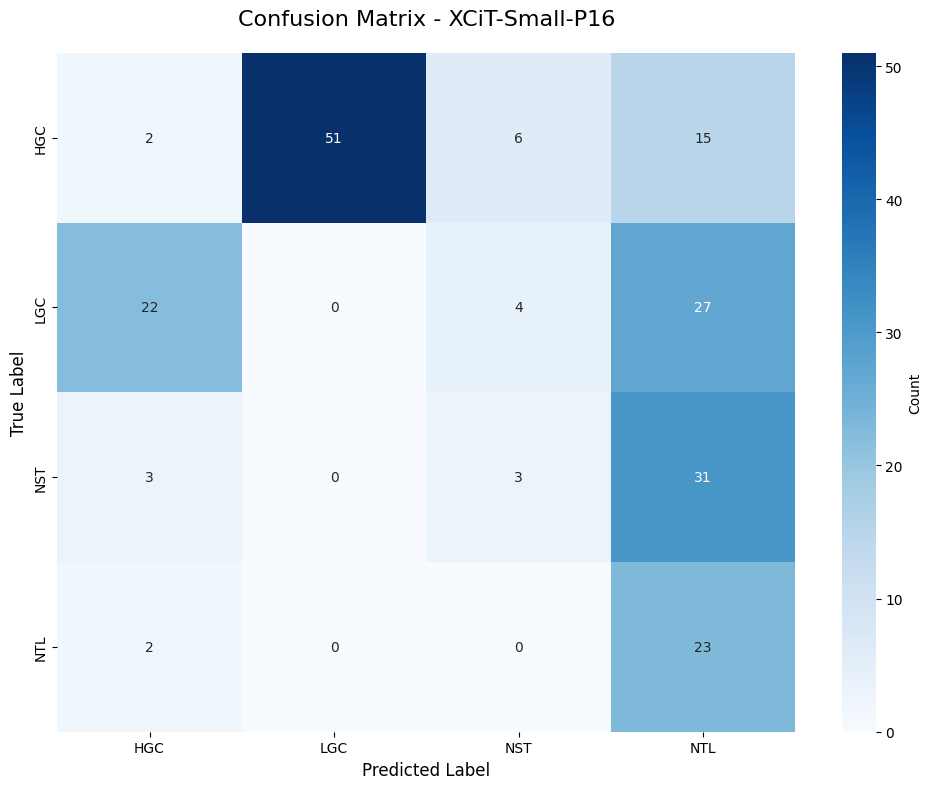

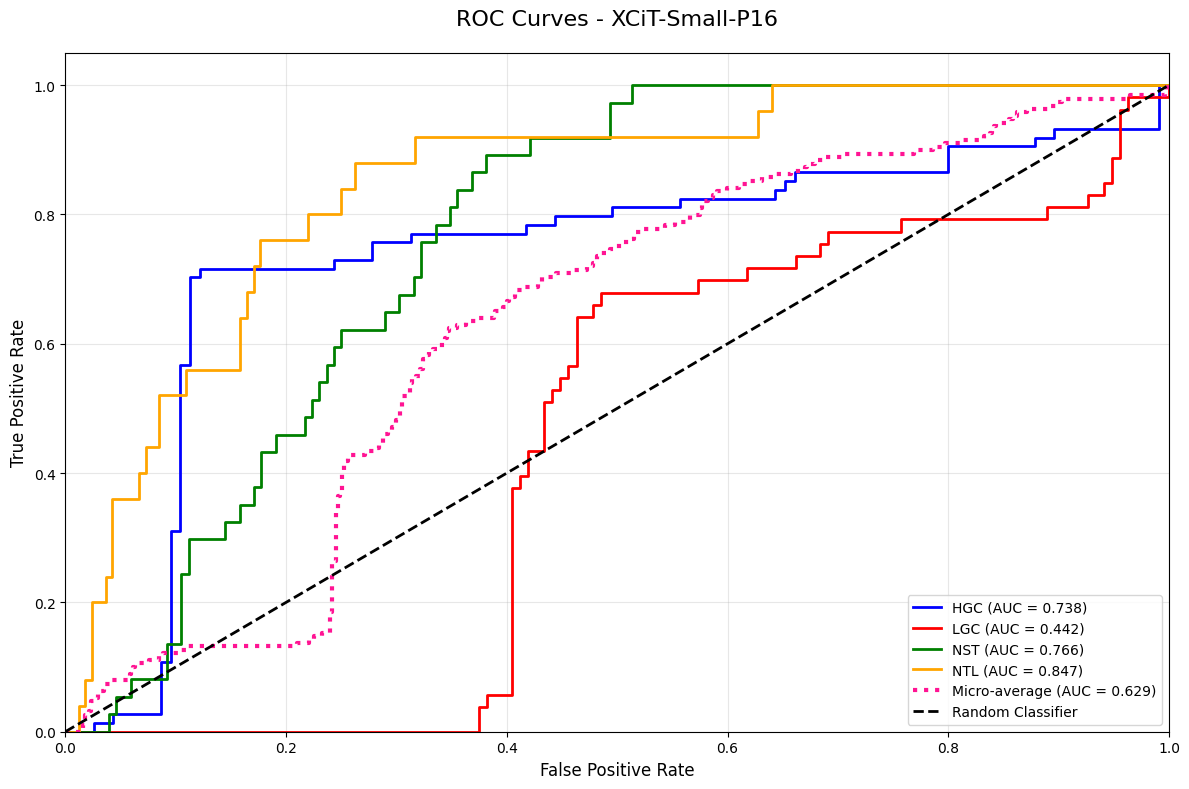


XCiT Small P16 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training XCiT Small P16")
print("=" * 80)

# Create model
xcit_small = create_xcit_model(num_classes=4, pretrained=True, model_type='small')

# Create trainer
trainer_xcit_small = ModelTrainer(xcit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_small = trainer_xcit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Small-P16")

# Plot training history
trainer_xcit_small.plot_training_history(save_path='xcit_small_p16_training_history.png')

# Evaluate model
results_xcit_small = trainer_xcit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_small['confusion_matrix'], class_names, 'XCiT-Small-P16',
                      save_path='xcit_small_p16_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_small = plot_roc_curves(results_xcit_small['labels'], results_xcit_small['probabilities'], class_names, 'XCiT-Small-P16',
                                       save_path='xcit_small_p16_roc_curves.png')

# Store results
results_xcit_small['model_name'] = 'XCiT-Small-P16'
results_xcit_small['roc_auc'] = roc_auc_xcit_small
all_results.append(results_xcit_small)

print("\nXCiT Small P16 training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'XCiT_Tiny_Small_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: XCiT_Tiny_Small_metrics.csv

Metrics Summary:
            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   XCiT-Tiny-P16         54.497354      2.066560             0.513197          0.562968      0.517101                0.545404             0.544974         0.529783       0.684932    0.675676  0.680272         74.0       0.392857    0.207547  0.271605         53.0       0.600000    0.648649  0.623377         37.0       0.375000        0.72  0.493151         25.0   0.746242   0.752125  0.799647  0.501387  0.873933  0.810000      